In [66]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [67]:
from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    classification_report, 
    confusion_matrix, 
    roc_auc_score, 
    precision_score, 
    recall_score,
)
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall

In [68]:
df = pd.read_csv("../our_analyses/dataset_prepared.csv")
df_test= pd.read_csv("../our_analyses/dataset_test_prepared.csv")

In [69]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

df=df.drop(['name', 'artists', 'album_name'], axis=1)
df_test=df_test.drop(['name', 'artists', 'album_name'], axis=1)

genre_groups = {
    # Dance/Electronic - Generi che sono comunemente associati alla musica da discoteca e da ballo elettronica.
    'j-dance': 0, 'techno': 0, 'chicago-house': 0, 'breakbeat': 0,
    
    # Ambient/Relaxing - Musica rilassante spesso usata per creare un'atmosfera tranquilla, per lo studio o il sonno.
    'happy': 1, 'sleep': 1, 'study': 1, 'disney': 1,
    
    # Global/Traditional - Musica che spesso ha radici culturali tradizionali o regionali.
    'bluegrass': 2, 'forro': 2, 'mandopop': 2, 'iranian': 2, 'indian': 2, 'brazil': 2,
    
    # Metal/Industrial - Generi noti per essere intensi, con sonorità pesanti o industriali.
    'black-metal': 3, 'industrial': 3,
    
    # Pop/World - Musica popolare che può includere influenze internazionali o etniche.
    'j-idol': 4, 'spanish': 4, 'afrobeat': 4,
    
    # Experimental/Electronic - Musica elettronica sperimentale che spesso spinge i confini del genere.
    'idm': 5
}


df['genre_group'] = df['genre'].map(genre_groups).astype(int)
df_test['genre_group'] = df_test['genre'].map(genre_groups).astype(int)

le = LabelEncoder()
df['explicit'] = le.fit_transform(df['explicit'])
df_test['explicit'] = le.transform(df_test['explicit'])

# Separazione delle features e dei target
X_train = df.drop(['genre_group', 'genre', 'mode', 'key', 'time_signature', 'explicit'], axis=1)
y_train = df['genre_group'].values
X_test = df_test.drop(['genre_group', 'genre', 'mode', 'key', 'time_signature', 'explicit'], axis=1)
y_test = df_test['genre_group'].values

scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

In [70]:
from sklearn.naive_bayes import GaussianNB, CategoricalNB

clf = GaussianNB()
clf.fit(X_train_norm, y_train)

y_train_pred = clf.predict(X_train_norm)
print("Accuracy sul set di addestramento:", accuracy_score(y_train, y_train_pred))

# Valutazione del classificatore sul set di test
y_test_pred = clf.predict(X_test_norm)
print("Accuracy sul set di test:", accuracy_score(y_test, y_test_pred))

Accuracy sul set di addestramento: 0.5000666666666667
Accuracy sul set di test: 0.4952


In [71]:
import plotly.figure_factory as ff
from sklearn.metrics import confusion_matrix

# Assumiamo che 'y_test' e 'y_test_pred' siano già definiti e contengano le etichette vere e predette dal tuo modello

# Genera la matrice di confusione
cf = confusion_matrix(y_test, y_test_pred)

# Definisci le etichette per i generi in base ai raggruppamenti definiti
genre_labels = ['Dance/Electronic', 'Ambient/Relaxing', 'Global/Traditional', 'Metal/Industrial', 'Pop/World', 'Experimental/Electronic']

# Crea la heatmap usando plotly
fig = ff.create_annotated_heatmap(z=cf, x=genre_labels, y=genre_labels,
                                  annotation_text=cf.astype(str), colorscale='Greens')

# Aggiorna il layout
fig.update_layout(title_text='Confusion Matrix', title_x=0.5,
                  xaxis=dict(title='Predicted Labels', tickangle=45),
                  yaxis=dict(title='True Labels', tickmode='array', tickvals=list(range(len(genre_labels))), ticktext=genre_labels),
                  yaxis_autorange='reversed')  # Reverse the y-axis to have the first class at the top

# Mostra il grafico
fig.show()


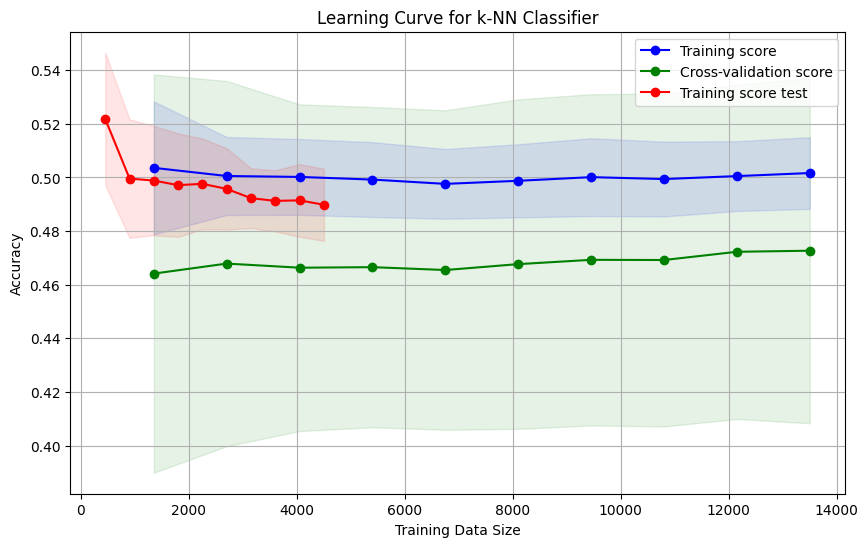

In [86]:
from sklearn.model_selection import learning_curve

# Assicurati che clf sia già definito e addestrato come nel codice precedente

# Genera la curva di apprendimento per il classificatore clf
train_sizes, train_scores, test_scores = learning_curve(
    estimator=clf,
    X=X_train_norm,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=10,
    scoring='accuracy',
    n_jobs=-1,
    shuffle=True,
    random_state=0
)

# Calcola la media e la deviazione standard per clf
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Disegna la curva di apprendimento
plt.figure(figsize=(10, 6))







# Genera la curva di apprendimento per il classificatore clf
train_sizes_test, train_scores_test, test_scores_test = learning_curve(
    estimator=clf,
    X=X_test_norm,
    y=y_test,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=10,
    scoring='accuracy',
    n_jobs=-1,
    shuffle=True,
    random_state=0
)

# Calcola la media e la deviazione standard per clf
train_mean_test = np.mean(train_scores_test, axis=1)
train_std_test = np.std(train_scores_test, axis=1)
test_mean_test = np.mean(test_scores_test, axis=1)
test_std_test = np.std(test_scores_test, axis=1)

# Curva per clf
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training score')
plt.plot(train_sizes, test_mean, 'o-', color='green', label='Cross-validation score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='green')

plt.plot(train_sizes_test, train_mean_test, 'o-', color='red', label='Training score test')
plt.fill_between(train_sizes_test, train_mean_test - train_std_test, train_mean_test + train_std_test, alpha=0.1, color='red')

# Aggiungi titolo e assegnazioni
plt.title('Learning Curve for k-NN Classifier')
plt.xlabel('Training Data Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.show()


In [73]:
import plotly.graph_objs as go
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Assicurati che clf_test sia già definito e addestrato come nel codice precedente

# Previsione delle probabilità per il set di test
t_score = clf.predict_proba(X_test_norm)  # Nota: clf è usato qui, non clf_test

# Binarizza il vettore delle etichette in un formato "one-vs-all"
y_test_binarize = label_binarize(y_test, classes=np.unique(y_train))  # Nota: usiamo y_test e y_train

# Calcola ROC curve e AUC per ciascuna classe
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = t_score.shape[1]

# Preparare i dati per il plot
traces = []

# Calcola la ROC curve per ogni classe
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarize[:, i], t_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    traces.append(go.Scatter(x=fpr[i], y=tpr[i], mode='lines', 
                             name=f'Class {i} (AUC = {roc_auc[i]:.2f})'))

# Aggiungi la linea diagonale che rappresenta il caso di "indovinare casualmente"
traces.append(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Chance', 
                         line=dict(dash='dash')))

# Crea il layout del plot
layout = go.Layout(title='Multiclass ROC Curve',
                   xaxis=dict(title='False Positive Rate'),
                   yaxis=dict(title='True Positive Rate'),
                   width=1000,
                   height=800,
                   showlegend=True,
                   legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1))

fig = go.Figure(data=traces, layout=layout)
fig.show()


# Categorical

In [74]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import CategoricalNB

# Preparazione delle colonne categoriche
cat_columns = ['mode', 'key', 'time_signature', 'explicit']

# Facciamo il Label Encoding per 'mode', 'key', 'time_signature' dato che sono categorici
le = LabelEncoder()

for col in cat_columns:
    df[col] = le.fit_transform(df[col])
    df_test[col] = le.transform(df_test[col])

# Ora, selezioniamo solo le colonne categoriche per il CategoricalNB
X_train_cat = df[cat_columns].values
y_train_cat = df['genre_group'].values

X_test_cat = df_test[cat_columns].values
y_test_cat = df_test['genre_group'].values

# Addestramento del classificatore Categorical Naive Bayes
clf_cat = CategoricalNB()
clf_cat.fit(X_train_cat, y_train_cat)

# Valutazione del classificatore sul set di addestramento
y_train_pred_cat = clf_cat.predict(X_train_cat)
print("Accuracy sul set di addestramento (CategoricalNB):", accuracy_score(y_train_cat, y_train_pred_cat))

# Valutazione del classificatore sul set di test
y_test_pred_cat = clf_cat.predict(X_test_cat)
print("Accuracy sul set di test (CategoricalNB):", accuracy_score(y_test_cat, y_test_pred_cat))


Accuracy sul set di addestramento (CategoricalNB): 0.32953333333333334
Accuracy sul set di test (CategoricalNB): 0.3378


In [76]:
import plotly.figure_factory as ff
from sklearn.metrics import confusion_matrix

# Assumiamo che 'y_test' e 'y_test_pred' siano già definiti e contengano le etichette vere e predette dal tuo modello

# Genera la matrice di confusione
cf = confusion_matrix(y_test_pred_cat, y_test_cat)

# Definisci le etichette per i generi in base ai raggruppamenti definiti
genre_labels = ['Dance/Electronic', 'Ambient/Relaxing', 'Global/Traditional', 'Metal/Industrial', 'Pop/World', 'Experimental/Electronic']

# Crea la heatmap usando plotly
fig = ff.create_annotated_heatmap(z=cf, x=genre_labels, y=genre_labels,
                                  annotation_text=cf.astype(str), colorscale='Greens')

# Aggiorna il layout
fig.update_layout(title_text='Confusion Matrix', title_x=0.5,
                  xaxis=dict(title='Predicted Labels', tickangle=45),
                  yaxis=dict(title='True Labels', tickmode='array', tickvals=list(range(len(genre_labels))), ticktext=genre_labels),
                  yaxis_autorange='reversed')  # Reverse the y-axis to have the first class at the top

# Mostra il grafico
fig.show()
